# Vulnerable groups probability distribution

The aim of this notebook is to estimate the probability of belonging in a vulnerable group, broken down by age and gender. 

Our exercise does not intend on having any meaningful medical interpretation, but rather serves the purpose of deriving potential mobility constrains based on the perception of vulnerability for different demographic groups.


Using Bayes' theorem, we define this probability as:

$$ P(at\_risk\mid pop\_group) = \frac{P(pop\_group\mid deaths) P(deaths)}{P(pop\_group)} * norm\_factor $$, where

$P(at\_risk\mid pop\_group) $ : the probability of a person being vulnerable, given their demographic group

$P(pop\_group\mid deaths) $ : the breakdown of covid-related deaths by demographic group

$P(deaths)$ : the pandemic mortality rate

$P(pop\_group)$ : the percentage of people belonging to a demographic group

$norm\_factor $ : a scaling factor that adjusts the risk probability so that all people over 70 are considered valnuarable. 

To calculate the left side of the equation, two ONS datasets are used as input:
* <a href="https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales">Deaths registered weekly in England and Wales, provisional</a>
* <a href="https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland">Estimates of the population for the UK, England and Wales, Scotland and Northern Ireland</a>

<i>Last visited: 29/04/2020</i>




The 100% vulnerability assumption for groups over 70 years old is based on <a href="https://www.gov.uk/government/publications/covid-19-guidance-on-social-distancing-and-for-vulnerable-people/guidance-on-social-distancing-for-everyone-in-the-uk-and-protecting-older-people-and-vulnerable-adults">government advice</a>, which considers all people of that age to be at increased risk regardless of medical conditions.

In [1]:
#import dependencies
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# set filepaths for the source datasets
filepath_pandemic_stats = os.path.join("data", "example_data", "stats", "publishedweek1620201.xls")
filepath_population = os.path.join("data", "example_data", "stats", "ukmidyearestimates20182019ladcodes.xls")

In [3]:
# read and transform the pandemic deaths dataset 
def read_pandemic_stats(filepath_pandemic_stats):
    """
    Reads and transforms pandemic deaths from the ONS "Deaths registered weekly in England and Wales, provisional" dataset
    Please note that the spreadsheet format may change in the future, requiring the update of the code.
    
    :params string filepath_pandemic_stats: Location of the ONS spreadsheet
    
    :returns: Pandas DataFrame
    """
    #read the dataset
    df = pd.read_excel(filepath_pandemic_stats, 
                       sheet_name='Covid-19 - Weekly occurrences',
                       skiprows=5
                      )[['Unnamed: 1','Year to date']]
    df.columns = ['group','deaths']

    #only keep gender and age data
    df['gender'] = df['group'].str.extract('(Males|Females|Deaths by region of usual residence)').ffill()
    df = df[df.gender.isin(['Males','Females'])].dropna()

    #create age bins
    df['group'] = df['group'].str.replace('<1','0-0').str.replace('90\+','90-120')
    df[['age_from','age_to']] = df.group.str.split('-',expand=True) # calculate age bands
    df['age_from'] = df['age_from'].map(int)
    df['age_to'] = df['age_to'].map(int)
    df['age_mid'] = (df['age_from'] + df['age_to']) / 2
    
    return df

#read and transform the population dataset
def read_pop(filepath_population, age_bins):
    """
    Reads and transforms population data from the ONS 
        "Estimates of the population for the UK, England and Wales, Scotland and Northern Ireland" dataset
    Please note that the spreadsheet format may change in the future, requiring the update of the code.
    
    :params string filepath_pandemic_stats: Location of the ONS spreadsheet
    :params lsit age_bins: A list of ages to create the age group bins

    :returns: Pandas DataFrame
    """
    
    #read the dataset
    pop = pd.concat([pd.read_excel(filepath_population,
                       sheet_name='MYE2 - '+x,skiprows=3).iloc[:2,4:].T.assign(gender=x) \
                    for x in ['Males','Females']])
    pop.columns = ['age','population','gender']

    #create age bins
    pop['group'] = pd.cut(pop.age,age_bins,right=False)
    pop['group'] = pop['group'].apply(lambda x:str(x.left) + '-' + str(x.right-1))

    #group by age group
    pop = pop.groupby(['gender','group'])[['population']].sum().reset_index()
    
    return pop

def calculate_bayesian_risk(pandemic_stats, population_stats, mortality_forecast = 60000):
    """
    Calculates the conditional probability of a person being at risk, given their demographic group (age and gender)
    
    :params dataframe pandemic_stats: pandemic mortality statistics, derived with the read_pandemic_stats function
    :params dataframe population_stats: population statistics, derived with the read_pop function
        
    :returns: Pandas DataFrame
    """
    #merge the two datasets
    df_prob = pd.merge(pandemic_stats,population_stats,on=['gender','group'])
    
    #calculate bayesian probability
    p_risk = mortality_forecast / df_prob.population.sum()

    #probability of being in a demographic group, given mortality
    df_prob['p_group_risk'] = df_prob['deaths'] / df_prob['deaths'].sum()

    #probability of being in a demographic group
    df_prob['p_group'] = df_prob['population'] / df_prob['population'].sum()

    #probability of mortality, given a demographic group
    df_prob['p_risk_group'] = df_prob['p_group_risk'] / df_prob['p_group'] * p_risk

    #scale vulnerability: we assume everyone above 70 to be in the vulnerable category
    scale_factor = df_prob[df_prob.age_from>=70].p_risk_group.min()
    df_prob['p_vulnerability'] = (df_prob['p_risk_group'] / scale_factor).apply(lambda x: min(x,1))
    
    return df_prob


In [4]:
pandemic_stats = read_pandemic_stats(filepath_pandemic_stats)
population_stats = read_pop(filepath_population,
                           age_bins=list(pandemic_stats.age_from.unique())+[121])

#calculate distribution
df = calculate_bayesian_risk(pandemic_stats, population_stats)

df.head()

/Users/fred.shone/.ve/pam/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: The default value of regex will change from True to False in a future version.


,group,deaths,gender,age_from,age_to,age_mid,population,p_group_risk,p_group,p_risk_group,p_vulnerability
0,0-0,0.0,Males,0,0,0.0,382332.0,0.000000,0.005755,0.000000,0.00000
1,1-4,0.0,Males,1,4,2.5,1625392.0,0.000000,0.024466,0.000000,0.00000
2,5-9,0.0,Males,5,9,7.0,2118231.0,0.000000,0.031884,0.000000,0.00000
3,10-14,0.0,Males,10,14,12.0,1977260.0,0.000000,0.029762,0.000000,0.00000
4,15-19,4.0,Males,15,19,17.0,1884238.0,0.000179,0.028362,0.000006,0.00454


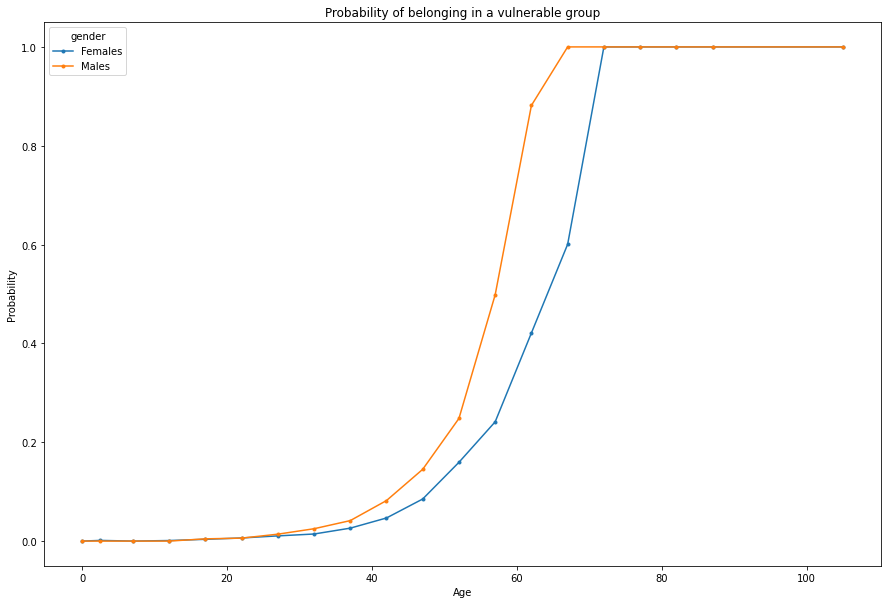

In [5]:
# inspect the results
def plot_probabilities(df, field='p_vulnerability'):
    df.set_index(['age_mid','gender'])[field].unstack(level='gender').plot(figsize=(15,10),marker='.',
                        title='Probability of belonging in a vulnerable group')
    plt.xlabel('Age')
    plt.ylabel('Probability')
    plt.show()
    
plot_probabilities(df,'p_vulnerability')

In [6]:
#probabilities to pass to PAM
df.set_index(['gender','age_from','age_to'])[['p_vulnerability']].unstack(level='gender').style.format('{:.2%}')

In [7]:
# create bins for converting age integer into bin value

In [8]:
bins = {(int(l), int(u)): v for l,u,v in zip(df.age_from, df.age_to, df.group)}
bins

{(0, 0): '0-0',
 (1, 4): '1-4',
 (5, 9): '5-9',
 (10, 14): '10-14',
 (15, 19): '15-19',
 (20, 24): '20-24',
 (25, 29): '25-29',
 (30, 34): '30-34',
 (35, 39): '35-39',
 (40, 44): '40-44',
 (45, 49): '45-49',
 (50, 54): '50-54',
 (55, 59): '55-59',
 (60, 64): '60-64',
 (65, 69): '65-69',
 (70, 74): '70-74',
 (75, 79): '75-79',
 (80, 84): '80-84',
 (85, 89): '85-89',
 (90, 120): '90-120'}

In [9]:
# convert diustribution into dictionary format
from collections import defaultdict

distribution = df[['group', 'gender', 'p_vulnerability']]
dist_dict = defaultdict(dict)
for idx, (age, gender, p) in distribution.iterrows():
    dist_dict[age][gender.lower()[:-1]] = p
dist_dict

defaultdict(dict,
            {'0-0': {'male': 0.0, 'female': 0.0},
             '1-4': {'male': 0.0, 'female': 0.0013855284091743934},
             '5-9': {'male': 0.0, 'female': 0.0},
             '10-14': {'male': 0.0, 'female': 0.0011364522204917167},
             '15-19': {'male': 0.0045395266149026,
              'female': 0.0035939038014075725},
             '20-24': {'male': 0.005964637435277999,
              'female': 0.006309446634005372},
             '25-29': {'male': 0.013990395202599667,
              'female': 0.010526982654066451},
             '30-34': {'male': 0.024998152308686884,
              'female': 0.014324224886588337},
             '35-39': {'male': 0.041439201935017565,
              'female': 0.026185424839142133},
             '40-44': {'male': 0.0820116602761988,
              'female': 0.04676965178044597},
             '45-49': {'male': 0.1452515221462011,
              'female': 0.08518411506480376},
             '50-54': {'male': 0.24821975252333797,

In [10]:
# rejig for old lopops bins

In [11]:
bins = [0, 5, 11, 18, 30, 65, 200]
labels = ['age5', 'age11', 'age18p', 'age30', 'age65', 'age65p']
df['lopops'] = pd.cut(df.age_mid, bins, right=False, labels=labels)
df_lopops = df.groupby(['lopops', 'gender']).p_vulnerability.mean().reset_index()

In [12]:
distribution = df_lopops[['lopops', 'gender', 'p_vulnerability']]
dist_dict = defaultdict(dict)
for idx, (age, gender, p) in distribution.iterrows():
    dist_dict[age][gender.lower()[:-1]] = p
dist_dict

defaultdict(dict,
            {'age5': {'female': 0.0006927642045871967, 'male': 0.0},
             'age11': {'female': 0.0, 'male': 0.0},
             'age18p': {'female': 0.0023651780109496447,
              'male': 0.0022697633074513},
             'age30': {'female': 0.008418214644035912,
              'male': 0.009977516318938832},
             'age65': {'female': 0.14207161124871104,
              'male': 0.27457830435243763},
             'age65p': {'female': 0.9334348034886809, 'male': 1.0}})